# LGB summary notebook

In [1]:
%matplotlib inline

# Scientific computing
import numpy as np
import pandas as pd
from scipy import interp

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#sns.set_context('paper')

# Machine Learning
# Model
from lightgbm import LGBMClassifier
# Splitter Classes
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
# Splitter Functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
# Model validation
from sklearn.model_selection import learning_curve
# Training metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Useful functions

Function `print_confusion_matrix`

In [2]:
def print_confusion_matrix(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    columnwidth = max([len(str(x)) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t\p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

Function `plot_confusion_matrix`

In [3]:
def plot_confusion_matrix(cm, labels, title, filename, normalize=True, save=True):
    # Create DataFrame
    df_cm = pd.DataFrame(cm, columns=labels, index=labels)
    df_cm.index.name = 'True label'
    df_cm.columns.name = 'Predicted label'
    
    # Normalize
    if normalize:
        df_cm = df_cm.div(df_cm.sum(axis=1), axis=0).round(decimals=2)
    
    # Plot
    fig, ax = plt.subplots()
    ax = sns.heatmap(df_cm, cmap='Blues', annot=True)
    axlim = ax.get_ylim()
    ax.set_ylim(axlim[0] + 0.5, axlim[1] - 0.5)
    if normalize:
        ax.set_title(title + ' (normalized)')
    else:
        ax.set_title(title)
    
    if save == True:
        fig.savefig(filename)

Function `plot_learning_curve`

In [4]:
def plot_learning_curve(estimator, X, y, title, filename, ylim=None, xscale=None, cv=None,
                        n_jobs=-1, n_curve_steps=20, save=True):
    train_sizes = np.linspace(.1, 1.0, n_curve_steps)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    if xscale is not None:
        plt.xscale(xscale)
    plt.xlabel('Training dataset size')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, linestyle='--', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')

    plt.legend(loc='best')
    
    if save == True:
        plt.savefig(filename)

Function `plot_roc_curve`

In [5]:
def plot_roc_curve(estimator, X, y, cv, title, filename, save=True):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = estimator.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    
    if save == True:
        plt.savefig(filename)

# Preparation

Load data and target from `classification/ris/OUT-classified-merged.h5` and load into numpy arrays.
- **Label `0` = NO GLITCH**
- **Label `1` = GLITCH**

In [6]:
first_cycle = True
with pd.HDFStore('../../classification/ris/OUT-classified-merged.h5', mode='r') as in_data:
    for group in ['GLITCH', 'NO_GLITCH']:
        if first_cycle == True:
            data = np.array(in_data[group].to_numpy())
            if group == 'GLITCH':
                target = np.ones(len(data))
            elif group == 'NO_GLITCH':
                target = np.zeros(len(data))
            else:
                print("ERROR.")
            first_cycle = False
        else:
            data = np.concatenate((data, in_data[group].to_numpy()))
            if group == 'GLITCH':
                target = np.concatenate((target, np.ones(len(in_data[group].to_numpy()))))
            elif group == 'NO_GLITCH':
                target = np.concatenate((target, np.zeros(len(in_data[group].to_numpy()))))
            else:
                print("ERROR.")
    data = np.concatenate((data, in_data['MULTI_GLITCH'].to_numpy()))
    target = np.concatenate((target, np.ones(len(in_data['MULTI_GLITCH'].to_numpy()))))

# Standard training

Initialize best hyper-parameters founded.

In [11]:
best_learning_rate = 0.112
best_min_data_in_leaf = 7
best_num_leaves = 30

## Cross validation

Use k-fold to make a cross validation of the model.

In [20]:
# k-fold parameters
n_splits = 5
n_repeats = 6

# Stratified k-fold
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
scores = np.array([])
# Make k-fold CV
ITER = 1
for train_index, test_index in rskf.split(data, target):
    print(ITER, '/', n_repeats * n_splits, end='\r')
    clf = LGBMClassifier(learning_rate=best_learning_rate,
                         min_data_in_leaf=best_min_data_in_leaf,
                         num_leaves=best_num_leaves)
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = target[train_index], target[test_index]
    clf.fit(X_train, y_train)
    train_score = clf.score(X_test, y_test)
    scores = np.append(scores, train_score)
    ITER += 1
    
# Print final score
print('Score:', scores.mean(), '+-', scores.std())

Score: 0.9131631093527667 +- 0.012066275448700911


## Confusion matrix, learning curve and ROC curve

### Confusion matrix

Text confusion matrix (without normalization)

       t\p    no glitch    glitch 
    no glitch   28555.0     945.0 
       glitch    5238.0   25262.0 


Graphic confusion matrix (normalized)



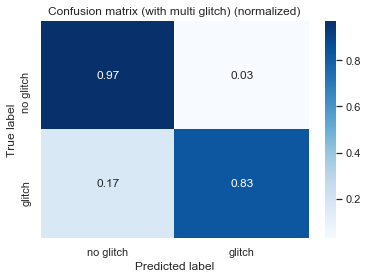

In [21]:
clf = LGBMClassifier(learning_rate=best_learning_rate,
                     min_data_in_leaf=best_min_data_in_leaf,
                     num_leaves=best_num_leaves)

cm = np.zeros(shape=(2,2), dtype=int)
# Compute the average confusion matrix
ITER = 1
for i in range(100):
    print(ITER, '/', 100, end='\r')
    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=None, stratify=target)
    # Train and predict
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    # Compute confusion matrix
    labels = [0., 1.]
    labels_text = ['no glitch', 'glitch']
    cm += confusion_matrix(y_test, y_pred, labels=labels)
    ITER += 1

# Print confusion matrix
print('Text confusion matrix (without normalization)\n')
print_confusion_matrix(cm, labels_text)
print('\n\nGraphic confusion matrix (normalized)\n')
plot_confusion_matrix(cm, labels_text, 'Confusion matrix (with multi glitch)', 'ris/plots/confusion_matrix.pdf', normalize=True)

### Learning curve

In [ ]:
# Classifier and cross-validation method
clf = LGBMClassifier(learning_rate=best_learning_rate,
                     min_data_in_leaf=best_min_data_in_leaf,
                     num_leaves=best_num_leaves)
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=0)

# Plot learning curve
plot_learning_curve(clf, data, target, 'Learning curve (with multi glitch)', 'ris/plots/learning_curve.pdf', cv=cv)

### ROC curve

In [ ]:
# Classifier and cross-validation method
clf = LGBMClassifier(learning_rate=best_learning_rate,
                     min_data_in_leaf=best_min_data_in_leaf,
                     num_leaves=best_num_leaves)
cv = StratifiedKFold(n_splits=5)

# Plot ROC curve
plot_roc_curve(clf, data, target, cv, 'ROC curve (with multi glitch)', 'ris/plots/roc_curve.pdf')

# Data augmentation

Data augmentation is a strategy that increase the diversity of data available for training models, without actually collecting new data. The data augmentation techniques used in this case are vertical flipping and translations.

**N.B.: the training time is extremely big!**

## Training

Due to the long training time, this part will be made in another script on `belen`.

### Simple training

In [12]:
# See data_augmentation-score.py

### Bagging Classifier training

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.

In [13]:
# See data_augmentation-score.py

## Confusion matrix, learning curve and ROC curve

Due to the long training time, this part will be made in another script on `belen`, called `data_augmentation_plots.py` .

### Confusion matrix

In [14]:
# Not implemented

### Learning curve

In [15]:
# Not implemented

### ROC curve

In [16]:
# Not implemented

# Sorted data

Glitches data have a peak, but it is in a random point of the plot. We can help the model by sorting data values: the new features queue will be about the same for all the data, while the first features will became discriminant. _In this case, data augmentation technique have no sense._

In [12]:
data_s = np.sort(data, axis=1)

Initialize best hyper-parameters founded.

In [13]:
best_learning_rate = 0.159
best_min_data_in_leaf = 41
best_num_leaves = 140

## Cross validation

Use k-fold to make a cross validation of the model.

In [14]:
# k-fold parameters
n_splits = 5
n_repeats = 6

# Stratified k-fold
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
scores = np.array([])
# Make k-fold CV
for train_index, test_index in rskf.split(data_s, target):
    clf = LGBMClassifier(learning_rate=best_learning_rate,
                         min_data_in_leaf=best_min_data_in_leaf,
                         num_leaves=best_num_leaves)
    X_train, X_test = data_s[train_index], data_s[test_index]
    y_train, y_test = target[train_index], target[test_index]
    clf.fit(X_train, y_train)
    train_score = clf.score(X_test, y_test)
    scores = np.append(scores, train_score)
    
# Print final score
print('Score:', scores.mean(), '+-', scores.std())

Score: 0.9974993692668911 +- 0.0030973915458550614


## Confusion matrix, learning curve and ROC curve

### Confusion matrix

Text confusion matrix (without normalization)

       t\p    no glitch    glitch 
    no glitch   29448.0      52.0 
       glitch     174.0   30326.0 


Graphic confusion matrix (normalized)



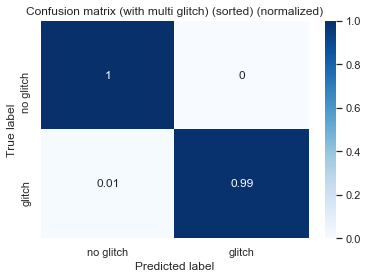

In [15]:
clf = LGBMClassifier(learning_rate=best_learning_rate,
                     min_data_in_leaf=best_min_data_in_leaf,
                     num_leaves=best_num_leaves)

cm = np.zeros(shape=(2,2), dtype=int)
# Compute the average confusion matrix
for i in range(100):
    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(data_s, target, test_size=0.3, random_state=None, stratify=target)
    # Train and predict
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    # Compute confusion matrix
    labels = [0., 1.]
    labels_text = ['no glitch', 'glitch']
    cm += confusion_matrix(y_test, y_pred, labels=labels)

# Print confusion matrix
print('Text confusion matrix (without normalization)\n')
print_confusion_matrix(cm, labels_text)
print('\n\nGraphic confusion matrix (normalized)\n')
plot_confusion_matrix(cm, labels_text, 'Confusion matrix (with multi glitch) (sorted)', 'ris/plots/s-confusion_matrix.pdf', normalize=True)

### Learning curve

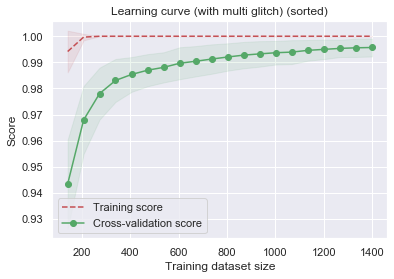

In [21]:
# Classifier and cross-validation method
clf = LGBMClassifier(learning_rate=best_learning_rate,
                     min_data_in_leaf=best_min_data_in_leaf,
                     num_leaves=best_num_leaves)
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=0)

# Plot learning curve
plot_learning_curve(clf, data_s, target, 'Learning curve (with multi glitch) (sorted)', 'ris/plots/s-learning_curve.pdf', cv=cv, n_jobs=1)

### ROC curve

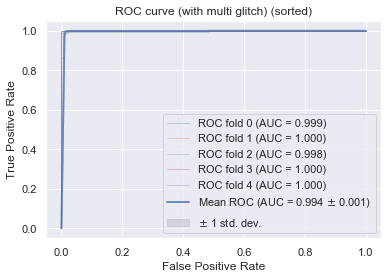

In [17]:
# Classifier and cross-validation method
clf = LGBMClassifier(learning_rate=best_learning_rate,
                     min_data_in_leaf=best_min_data_in_leaf,
                     num_leaves=best_num_leaves)
cv = StratifiedKFold(n_splits=5)

# Plot ROC curve
plot_roc_curve(clf, data_s, target, cv, 'ROC curve (with multi glitch) (sorted)', 'ris/plots/s-roc_curve.pdf')